In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append("./..")

from data import PollenDataset

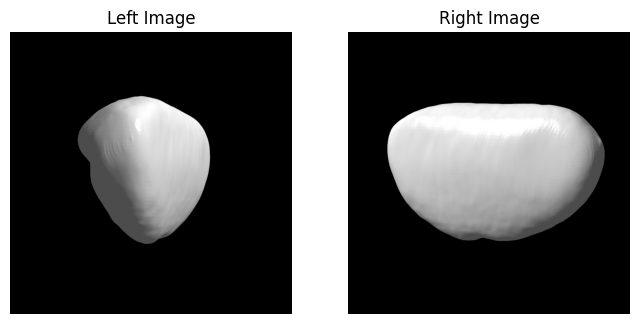

In [20]:
dataset = PollenDataset(image_transforms=transforms.ToTensor())

(left_img, right_img), (vertices, faces) = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [42]:
def lookat(camera_position, target, up):
    """
    Compute the camera extrinsic matrix (R|t) given a camera position, target, and up vector.
    """
    camera_position = np.array(camera_position)
    target = np.array(target)
    up = np.array(up)

    forward = target - camera_position
    forward /= np.linalg.norm(forward)
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    true_up = np.cross(forward, right)
    
    R = np.vstack([right, true_up, forward])
    t = -R @ camera_position
    RT = np.hstack([R, t.reshape(-1, 1)])
    return RT

def get_intrinsic(f, image_width, image_height):
    """
    Create an intrinsic matrix with focal length f and principal point at the image center.
    """
    cx = image_width / 2
    cy = image_height / 2
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]])
    return K

def project_voxels(voxels, K, RT, eps=0):
    """
    Project 3D points (voxels) into 2D image coordinates using safe division.
    - voxels: (N, 3) numpy array.
    - K: (3, 3) intrinsic matrix.
    - RT: (3, 4) extrinsic matrix.
    Returns an (N, 2) array with pixel coordinates.
    """
    N = voxels.shape[0]
    ones = np.ones((N, 1))
    voxels_hom = np.hstack([voxels, ones]).T
    proj = K @ (RT @ voxels_hom)
    depths = proj[2, :]
    
    safe_depths = np.where(np.abs(depths) < eps, np.nan, depths)
    
    proj = proj / safe_depths
    return proj[:2, :].T



In [49]:
target = np.array([0, 0, 0])
up = np.array([0, 0, 1])

front_cam_position = [0.0, -1.0, 0.0]
RT_front = lookat(front_cam_position, target, up)

side_cam_position = [1.0, 0.0, 0.0]
RT_side = lookat(side_cam_position, target, up)

In [50]:
def create_voxel_grid(grid_size, bounds):
    """
    Create a voxel grid.
    - grid_size: number of points along each dimension.
    - bounds: tuple of ((xmin, xmax), (ymin, ymax), (zmin, zmax)).
    Returns an (N, 3) array of voxel coordinates.
    """
    xs = np.linspace(bounds[0][0], bounds[0][1], grid_size)
    ys = np.linspace(bounds[1][0], bounds[1][1], grid_size)
    zs = np.linspace(bounds[2][0], bounds[2][1], grid_size)
    xv, yv, zv = np.meshgrid(xs, ys, zs, indexing='ij')
    voxels = np.stack([xv, yv, zv], axis=-1).reshape(-1, 3)
    return voxels

grid_size = 32
voxels = create_voxel_grid(grid_size, bounds=((-1, 1), (-1, 1), (-1, 1)))


In [51]:
def get_silhouette(image_tensor, threshold=0.5):
    """
    Convert a grayscale image tensor to a binary silhouette.
    Ensures the output is 2D.
    """
    if image_tensor.ndim == 3 and image_tensor.shape[0] == 1:
        image_tensor = image_tensor.squeeze(0)
    return (image_tensor > threshold).astype(np.float32)


def carve_voxels(voxels, image, K, RT):
    """
    For each voxel, project it into the image plane using the given camera parameters.
    Return a boolean mask indicating which voxels project inside the silhouette.
    - voxels: (N, 3) numpy array.
    - image: 2D numpy array (silhouette) with nonzero values indicating object.
    """
    silhouette = get_silhouette(image)
    proj_coords = project_voxels(voxels, K, RT)
    valid = np.ones(len(voxels), dtype=bool)
    
    H, W = silhouette.shape
    for i, (x, y) in enumerate(proj_coords):
        if not np.isfinite(x) or not np.isfinite(y):
            valid[i] = False
            continue
        
        x_pix, y_pix = int(round(x)), int(round(y))
        if x_pix < 0 or x_pix >= W or y_pix < 0 or y_pix >= H:
            valid[i] = False
        else:
            if silhouette[y_pix, x_pix] == 0:
                valid[i] = False
    return valid

In [52]:
left_img_np = left_img.numpy()
right_img_np = right_img.numpy()

print("Left image numpy shape:", left_img_np.shape)
print("Right image numpy shape:", right_img_np.shape)

valid_left = carve_voxels(voxels, left_img_np, K, RT_front)
valid_right = carve_voxels(voxels, right_img_np, K, RT_front)

visual_hull_mask = valid_left & valid_right
visual_hull_voxels = voxels[visual_hull_mask]

print(f"Total voxels: {voxels.shape[0]}")
print(f"Voxels in visual hull: {visual_hull_voxels.shape[0]}")


Left image numpy shape: (1, 1024, 1024)
Right image numpy shape: (1, 1024, 1024)


C:\Users\fahrn\AppData\Local\Temp\ipykernel_11368\1960048165.py:49: RuntimeWarning: divide by zero encountered in divide
  proj = proj / safe_depths  # This will yield NaN for problematic voxels
C:\Users\fahrn\AppData\Local\Temp\ipykernel_11368\1960048165.py:49: RuntimeWarning: invalid value encountered in divide
  proj = proj / safe_depths  # This will yield NaN for problematic voxels


Total voxels: 32768
Voxels in visual hull: 31744


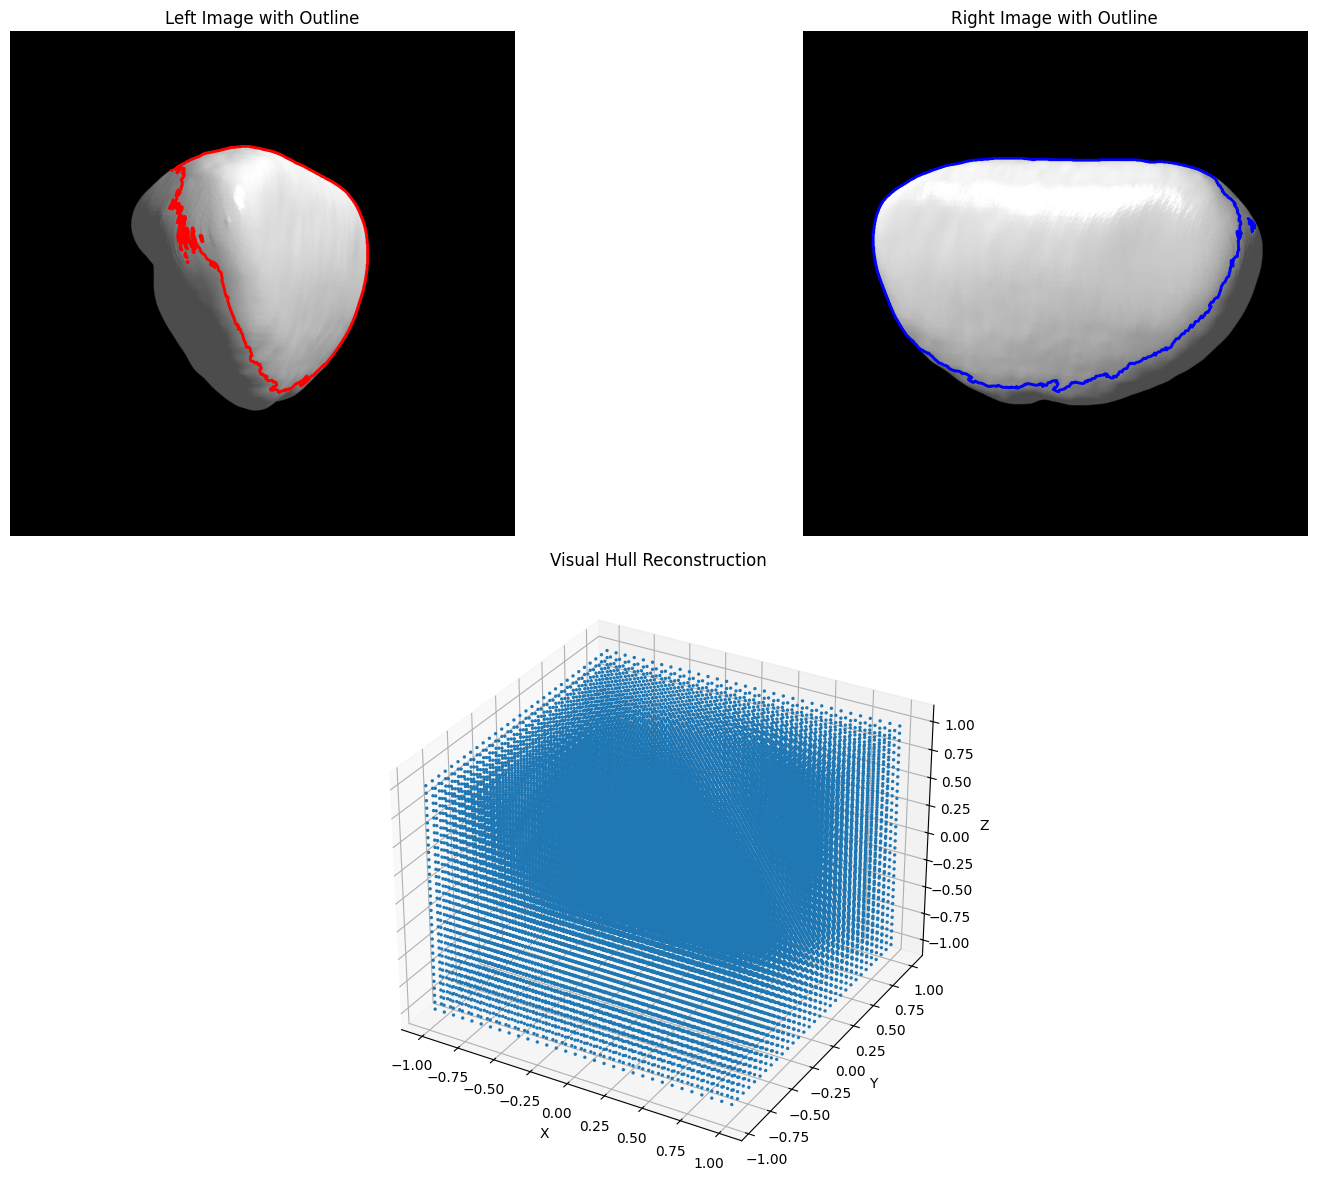

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

silhouette_left = get_silhouette(left_img_np)
silhouette_right = get_silhouette(right_img_np)

contours_left = measure.find_contours(silhouette_left, level=0.99)
contours_right = measure.find_contours(silhouette_right, level=0.99)

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])

ax_img_left = fig.add_subplot(gs[0, 0])
ax_img_left.imshow(left_img_np.squeeze(0), cmap='gray')
for contour in contours_left:
    ax_img_left.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
ax_img_left.set_title("Left Image with Outline")
ax_img_left.axis('off')

ax_img_right = fig.add_subplot(gs[0, 1])
ax_img_right.imshow(right_img_np.squeeze(0), cmap='gray')
for contour in contours_right:
    ax_img_right.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
ax_img_right.set_title("Right Image with Outline")
ax_img_right.axis('off')

ax_3d = fig.add_subplot(gs[1, :], projection='3d')
ax_3d.scatter(visual_hull_voxels[:, 0],
              visual_hull_voxels[:, 1],
              visual_hull_voxels[:, 2],
              s=2, alpha=1)
ax_3d.set_title("Visual Hull Reconstruction")
ax_3d.set_xlabel("X")
ax_3d.set_ylabel("Y")
ax_3d.set_zlabel("Z")

plt.tight_layout()
plt.show()
